In [1]:
import os
import sys

sys.path.insert(0, 'C:/Users/amanu/OneDrive/Desktop/KIFIYA_10_ACADEMY/TellCo/')

In [2]:
import pickle
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

import sys, os
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from plotting import PlotDataFrame
warnings.filterwarnings('ignore')

In [3]:
from scripts.utils import Util

In [4]:
#Initialize Plot
my_plt = PlotDataFrame()

df_tele = pd.read_csv("../data/cleaned_telecom_data.csv")
df_tele.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149996 entries, 0 to 149995
Data columns (total 56 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Unnamed: 0                        149996 non-null  int64  
 1   Bearer Id                         149996 non-null  int64  
 2   Start                             149996 non-null  object 
 3   Start ms                          149996 non-null  float64
 4   End                               149996 non-null  object 
 5   End ms                            149996 non-null  float64
 6   Dur. (ms)                         149996 non-null  float64
 7   IMSI                              149996 non-null  int64  
 8   MSISDN/Number                     149996 non-null  int64  
 9   IMEI                              149996 non-null  int64  
 10  Last Location Name                149996 non-null  object 
 11  Avg RTT DL (ms)                   149996 non-null  f

In [5]:
# Select Necessary Columns
df_tele_experience = df_tele[['MSISDN/Number','Avg RTT DL (ms)','Avg RTT UL (ms)','Avg Bearer TP DL (kbps)','Avg Bearer TP UL (kbps)',
    'TCP DL Retrans. Vol (Bytes)','TCP UL Retrans. Vol (Bytes)','Handset Type']]
df_tele_experience

,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Handset Type
0,33664962239,42.0,5.0,23.00,44.0,19520.00,7230.0,Samsung Galaxy A5 Sm-A520F
1,33681854413,65.0,5.0,16.00,26.0,19520.00,7230.0,Samsung Galaxy J5 (Sm-J530)
2,33760627129,102.0,5.0,6.00,9.0,19520.00,7230.0,Samsung Galaxy A8 (2018)
3,33750343200,102.0,5.0,44.00,44.0,19520.00,7230.0,undefined
4,33699795932,102.0,5.0,6.00,9.0,19520.00,7230.0,Samsung Sm-G390F
...,...,...,...,...,...,...,...,...
149991,33762146363,27.0,2.0,62.00,54.0,7625398.75,162614.0,Apple iPhone 6S Plus (A1687)
149992,33761274518,37.0,4.0,23.00,40.0,7625398.75,162614.0,Apple iPhone 6S (A1688)
149993,33626114091,46.0,6.0,43.00,41.0,7625398.75,162614.0,Apple iPhone Xr (A2105)
149994,33645655643,121.0,9.0,55.00,54.0,7625398.75,162614.0,Samsung Galaxy J5 (Sm-J530)


In [15]:
#Caluclating the totals
df_tele_experience['Total Avg RTT (ms)'] = df_tele_experience['Avg RTT DL (ms)'] + df_tele_experience['Avg RTT UL (ms)']
df_tele_experience['Total Avg Bearer TP (kbps)'] = df_tele_experience['Avg Bearer TP DL (kbps)'] + df_tele_experience['Avg Bearer TP UL (kbps)']
df_tele_experience['Total TCP Retrans. Vol (Bytes)'] = df_tele_experience['TCP DL Retrans. Vol (Bytes)'] + df_tele_experience['TCP UL Retrans. Vol (Bytes)']
df_tele_experience.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149996 entries, 0 to 149995
Data columns (total 12 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   MSISDN/Number                   149996 non-null  int64  
 1   Avg RTT DL (ms)                 149996 non-null  float64
 2   Avg RTT UL (ms)                 149996 non-null  float64
 3   Avg Bearer TP DL (kbps)         149996 non-null  float64
 4   Avg Bearer TP UL (kbps)         149996 non-null  float64
 5   TCP DL Retrans. Vol (Bytes)     149996 non-null  float64
 6   TCP UL Retrans. Vol (Bytes)     149996 non-null  float64
 7   Handset Type                    149996 non-null  object 
 8   Cluster                         149996 non-null  int32  
 9   Total Avg RTT (ms)              149996 non-null  float64
 10  Total Avg Bearer TP (kbps)      149996 non-null  float64
 11  Total TCP Retrans. Vol (Bytes)  149996 non-null  float64
dtypes: float64(9), i

In [18]:
print(df_tele_experience.columns)


Index(['MSISDN/Number', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)',
       'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'Handset Type', 'Cluster', 'Total Avg RTT (ms)',
       'Total Avg Bearer TP (kbps)', 'Total TCP Retrans. Vol (Bytes)'],
      dtype='object')


In [19]:
print(df_tele_experience.head())


   MSISDN/Number  Avg RTT DL (ms)  Avg RTT UL (ms)  Avg Bearer TP DL (kbps)  \
0    33664962239             42.0              5.0                     23.0   
1    33681854413             65.0              5.0                     16.0   
2    33760627129            102.0              5.0                      6.0   
3    33750343200            102.0              5.0                     44.0   
4    33699795932            102.0              5.0                      6.0   

   Avg Bearer TP UL (kbps)  TCP DL Retrans. Vol (Bytes)  \
0                     44.0                      19520.0   
1                     26.0                      19520.0   
2                      9.0                      19520.0   
3                     44.0                      19520.0   
4                      9.0                      19520.0   

   TCP UL Retrans. Vol (Bytes)                 Handset Type  Cluster  \
0                       7230.0   Samsung Galaxy A5 Sm-A520F        2   
1                       72

In [21]:
#aggregating data in the DataFrame df_tele_user_experience based on the 'MSISDN/Number' column. 
df_tele_experience_agg = df_tele_experience.groupby(
    'MSISDN/Number').agg({
        'Total Avg RTT (ms)': 'sum',
        'Total Avg Bearer TP (kbps)': 'sum',
        'Total TCP Retrans. Vol (Bytes)': 'sum',
        'Handset Type': [lambda x: x.mode()[0]]})
df_tele_experience_agg.head()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes),Handset Type
,sum,sum,sum,<lambda>
MSISDN/Number,,,,
33601001722,46.0,76.0,2895381.00,Huawei P20 Lite Huawei Nova 3E
33601001754,31.0,99.0,7653221.75,Apple iPhone 7 (A1778)
33601002511,59.0,97.0,4150403.00,undefined
33601007832,84.0,248.0,2396.00,Apple iPhone 5S (A1457)
33601008617,119.0,43164.5,8014650.75,Apple iPhone Se (A1723)


In [23]:
#Creating and Loading to a new aggregating dataframe
df_tele_experience_agg_new = pd.DataFrame(columns=[
    "Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)",
    "Handset Type"])

df_tele_experience_agg_new["Total Avg RTT (ms)"] = df_tele_experience_agg["Total Avg RTT (ms)"]['sum']
df_tele_experience_agg_new["Total Avg Bearer TP (kbps)"] = df_tele_experience_agg["Total Avg Bearer TP (kbps)"]['sum']
df_tele_experience_agg_new["Total TCP Retrans. Vol (Bytes)"] = df_tele_experience_agg["Total TCP Retrans. Vol (Bytes)"]['sum']
df_tele_experience_agg_new["Handset Type"] = df_tele_experience_agg["Handset Type"]['<lambda>']
df_tele_experience_agg_new.head() 

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes),Handset Type
MSISDN/Number,,,,
33601001722,46.0,76.0,2895381.00,Huawei P20 Lite Huawei Nova 3E
33601001754,31.0,99.0,7653221.75,Apple iPhone 7 (A1778)
33601002511,59.0,97.0,4150403.00,undefined
33601007832,84.0,248.0,2396.00,Apple iPhone 5S (A1457)
33601008617,119.0,43164.5,8014650.75,Apple iPhone Se (A1723)


In [24]:
#Top And Bottom 10, Most Frequent TCP Values
tele_tcp = df_tele_experience_agg_new.sort_values('Total TCP Retrans. Vol (Bytes)', ascending=False)
# top_10 = tele_tcp.head(10)['Total TCP Retrans. Vol (Bytes)']
top_10 = tele_tcp.head(10)['Total TCP Retrans. Vol (Bytes)']
top_10

MSISDN/Number
33604515716    5.521261e+07
33665639832    5.347205e+07
33662840755    4.910787e+07
33699231421    4.674718e+07
33660214653    4.670146e+07
33760112066    4.657204e+07
33659822913    4.648272e+07
33665778430    4.647687e+07
33699248832    4.615518e+07
33763730582    4.604499e+07
Name: Total TCP Retrans. Vol (Bytes), dtype: float64

In [25]:
bottom_10 = tele_tcp.tail(10)['Total TCP Retrans. Vol (Bytes)']
bottom_10

MSISDN/Number
33660364301    97.0
33681989306    97.0
33650676273    97.0
33761671649    97.0
33650128412    97.0
33689874306    97.0
33669388268    92.0
33662545528    51.0
33761565421    44.0
33666097086    41.0
Name: Total TCP Retrans. Vol (Bytes), dtype: float64

In [26]:
most_10 = df_tele_experience_agg_new['Total TCP Retrans. Vol (Bytes)'].value_counts().head(10)
most_10

Total TCP Retrans. Vol (Bytes)
7.791197e+06    4192
7.626693e+06     261
1.558239e+07     249
7.626729e+06     104
1.432000e+03      87
9.854750e+05      81
1.150670e+05      80
1.441000e+03      70
1.328130e+06      69
1.332524e+06      67
Name: count, dtype: int64

In [27]:
tele_tp = df_tele_experience_agg_new.sort_values('Total Avg Bearer TP (kbps)', ascending=False)
top_10 = tele_tp.head(10)['Total Avg Bearer TP (kbps)']
top_10

MSISDN/Number
33762333464    439553.25
33659546392    415234.75
33614892860    373257.25
33659359429    360005.25
33662780927    327377.75
33604515716    318240.50
33699248832    317299.00
33658263267    313356.50
33699327554    311128.00
33658946065    307123.50
Name: Total Avg Bearer TP (kbps), dtype: float64

In [28]:
most_10 = df_tele_experience_agg_new['Total Avg Bearer TP (kbps)'].value_counts().head(10)
most_10

Total Avg Bearer TP (kbps)
51948.75    2746
15.00       2671
63.00       2060
97.00       1022
90.00        998
98.00        967
96.00        864
99.00        853
89.00        810
95.00        793
Name: count, dtype: int64

In [29]:
most_10 = df_tele_experience_agg_new['Total Avg Bearer TP (kbps)'].value_counts().head(10)
most_10

Total Avg Bearer TP (kbps)
51948.75    2746
15.00       2671
63.00       2060
97.00       1022
90.00        998
98.00        967
96.00        864
99.00        853
89.00        810
95.00        793
Name: count, dtype: int64

In [30]:
df_tele_handset_type = df_tele_experience_agg_new.groupby('Handset Type').mean()
df_tele_handset_type.head()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
Handset Type,,,
A-Link Telecom I. Cubot A5,42.0,23510.00,7640451.75
A-Link Telecom I. Cubot Note Plus,129.0,6699.00,616213.00
A-Link Telecom I. Cubot Note S,125.0,8937.00,7692650.75
A-Link Telecom I. Cubot Nova,44.0,49769.25,137170.00
A-Link Telecom I. Cubot Power,43.0,49561.25,8041.00


In [31]:
#Top handset_type based on the 'Total Avg Bearer TP (kbps)' 
df_tele_handset_tp = df_tele_handset_type.sort_values('Total Avg Bearer TP (kbps)', ascending=False)
df_tele_handset_tp.head()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
Handset Type,,,
Huawei Par-Lx9,213.5,125901.500,2.896635e+06
Spa Condor Elect. Allure M2,90.0,100472.500,8.901600e+04
Spa Condor Elect. Plume L2,259.0,94461.250,1.081543e+07
Lg-H860,90.0,79067.500,7.658525e+06
Asustek Wireless-Ac1200 Lte Router,207.0,78176.625,1.307857e+06


### Average TCP Retransmission View Per Handset Type

In [32]:
#Top handset_type based on TCP Retransmission' 

df_tele_handset_tcp = df_tele_handset_type.sort_values(
    'Total TCP Retrans. Vol (Bytes)', ascending=False)
df_tele_handset_tcp.head()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
Handset Type,,,
Huawei Me909S-120,205.500000,1548.500000,1.667312e+07
Sierra Wireless Usb305,245.000000,31360.000000,1.558239e+07
Wistron M18Qw,91.000000,26826.000000,1.420021e+07
Huawei B618S-22D,385.666667,77484.833333,1.096794e+07
Spa Condor Elect. Plume L2,259.000000,94461.250000,1.081543e+07


### Handling Outliers

<Axes: >

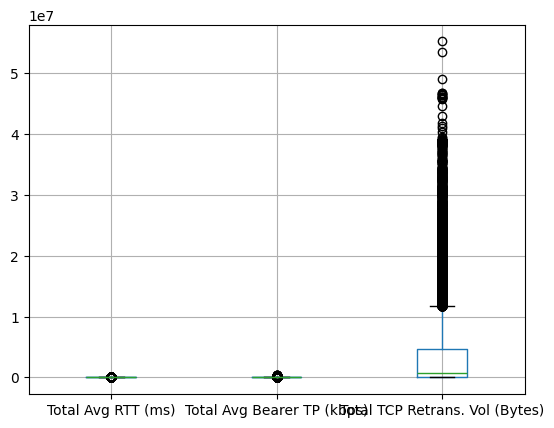

In [33]:
df_tele_experience_agg_new.boxplot()

In [34]:
#Overview of user_experience metrics
df_tele_experience_agg_new = df_tele_experience_agg_new[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]]
my_util = Util(df_tele_experience_agg_new)
my_util.getOverview(["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"])

Name of columns,Total Avg Bearer TP (kbps),Total Avg RTT (ms),Total TCP Retrans. Vol (Bytes)
Min,0.0,0.0,41.0
Q1,97.0,40.0,85122.0
Median,315.0,65.5,714852.0
Q3,25464.0,121.0,4717979.875
Max,439553.25,1299.0,55212607.0
IQR,25367.0,81.0,4632857.875
Lower fence,-37953.5,-81.5,-6864164.8125
Upper fence,63514.5,242.5,11667266.6875
Skew,3.249378,3.378034,2.760163
Number_of_outliers,5051,4612,3703


In [35]:
# replace outliers in specified columns of a DataFrame with the upper and lower fences.
my_util.replace_outliers_with_fences(["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"])
my_util.getOverview(["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"])

Name of columns,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
Min,0.0,0.0,41.0
Q1,40.0,97.0,85122.0
Median,65.5,315.0,714852.0
Q3,121.0,25464.0,4717979.875
Max,242.5,63514.5,11667266.6875
IQR,81.0,25367.0,4632857.875
Lower fence,-81.5,-37953.5,-6864164.8125
Upper fence,242.5,63514.5,11667266.6875
Skew,1.220298,1.215237,1.174345
Number_of_outliers,0,0,0


<Axes: >

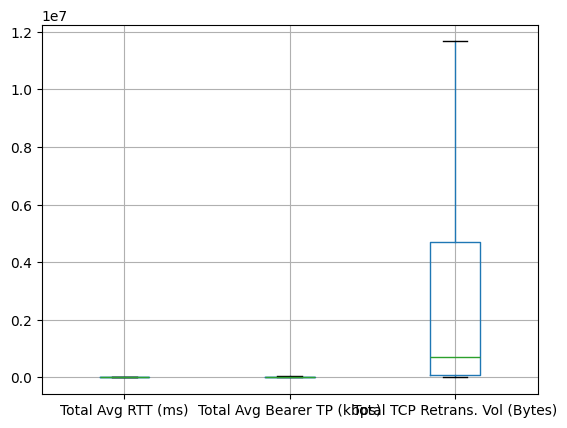

In [36]:
df_tele_experience_agg_new.boxplot()

### K means Clustering

In [37]:
# Instantiate StandardScaler:
scaler_instance = StandardScaler()
# Fit and Transform:
scaled_data = scaler_instance.fit_transform(df_tele_experience_agg_new)
scaled_data

array([[-0.6679844 , -0.67960534,  0.07451032],
       [-0.93159296, -0.67849033,  1.46556913],
       [-0.43952366, -0.67858728,  0.44144345],
       ...,
       [-0.80857563, -0.68324125,  1.45779116],
       [-0.80857563, -0.68168993, -0.73675877],
       [-0.82614954, -0.68319278, -0.76110282]])

In [38]:
normalized_data = normalize(scaled_data)
normalized_data

array([[-0.69884991, -0.71100781,  0.07795321],
       [-0.49966577, -0.36391258,  0.78606727],
       [-0.47714196, -0.73666676,  0.47922607],
       ...,
       [-0.44880935, -0.37924104,  0.80916401],
       [-0.62732907, -0.52888548, -0.57161034],
       [-0.62837272, -0.51963922, -0.57889792]])

In [39]:
# Instantiate and Fit KMeans Retrieve Cluster Labels:
kmeans = KMeans(n_clusters=3, random_state=1).fit(normalized_data)
kmeans.labels_

array([0, 1, 0, ..., 1, 0, 0], dtype=int32)

In [40]:
# inserting a new column labeled 'cluster' into the DataFrame 
df_tele_experience_agg_new.insert(0, 'cluster', kmeans.labels_)
df_tele_experience_agg_new

,cluster,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
MSISDN/Number,,,,
33601001722,0,46.0,76.0,2895381.00
33601001754,1,31.0,99.0,7653221.75
33601002511,0,59.0,97.0,4150403.00
33601007832,0,84.0,248.0,2396.00
33601008617,1,119.0,43164.5,8014650.75
...,...,...,...,...
33789996170,0,52.0,10365.0,218045.00
33789997247,0,40.0,116.0,247983.00
3197020876596,1,38.0,1.0,7626618.75


In [41]:
df_tele_experience_agg_new['cluster'].value_counts()

cluster
0    48499
1    40610
2    17744
Name: count, dtype: int64

In [42]:
# summary of the statistical information for data points belonging to cluster 0
cluster0 = df_tele_experience_agg_new[df_tele_experience_agg_new["cluster"]==0]
cluster0[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]].describe()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
count,48499.000000,48499.000000,4.849900e+04
mean,45.631023,2440.338749,6.544964e+05
std,17.420818,6157.623018,1.091624e+06
min,0.000000,0.000000,4.100000e+01
25%,31.000000,82.000000,2.549450e+04
50%,42.000000,105.000000,1.476740e+05
75%,58.000000,241.000000,7.339410e+05
max,89.500000,36871.000000,5.994350e+06


In [43]:
# summary of the statistical information for data points belonging to cluster 1
cluster1 = df_tele_experience_agg_new[df_tele_experience_agg_new["cluster"]==1]
cluster1[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]].describe()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
count,40610.00000,40610.000000,4.061000e+04
mean,107.85575,30816.236315,5.772027e+06
std,64.56431,23879.449232,3.594047e+06
min,8.00000,0.000000,1.690000e+02
25%,58.00000,239.000000,2.186734e+06
50%,91.00000,36165.750000,7.625544e+06
75%,143.00000,51948.750000,7.791197e+06
max,242.50000,63514.500000,1.166727e+07


In [44]:
# summary of the statistical information for data points belonging to cluster 2
cluster2 = df_tele_experience_agg_new[df_tele_experience_agg_new["cluster"]==2]
cluster2[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]].describe()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
count,17744.000000,17744.000000,1.774400e+04
mean,134.335071,7678.558865,9.019640e+05
std,35.621235,10065.170087,1.175276e+06
min,79.000000,0.000000,1.600000e+02
25%,113.000000,188.000000,8.425500e+04
50%,126.000000,2388.000000,3.607280e+05
75%,145.000000,12934.250000,1.302865e+06
max,242.500000,58598.250000,7.666637e+06


### Save The Dataframe and Model

In [45]:
df_tele_experience_agg_new.to_csv('../data/telecom_experience_data.csv')

In [47]:
with open("../models/telecom_experience.pkl", "wb") as f:
    pickle.dump(kmeans, f)